# Libraries
<a id="step-1"></a>
## Import the required libraries

In [ ]:
# from google.colab import drive
# drive.mount('/text/drive')

In [1]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# gensim library is installed for topic modeling
#!pip install gensim==3.8

# Get data
## Import Dataset

In [4]:
''' 
    /*-------------------- LOAD_dataset ----------------
    | Function  : read_csv()
    | Purpose   : Read a Dataset in CSV file Format 
    | Arguments : 
    |       path    : Path to dataset file
    |       dataset : Dataset file name
    | Return    :
    |       dataset : Dataset in DataFrame Format
    *---------------------------------------------------------*/
'''

# Read the Data in CSV Format
dataset1 = pd.read_excel('Comments-English-leak.xlsx')
dataset2 = pd.read_excel('Comments-English-Bioweapon.xlsx')
dataset3 = pd.read_excel('Comments-English-5G.xlsx')
dataset4 = pd.read_excel('Comments-English-lab.xlsx')
dataset5 = pd.read_excel('Comments-English-populationcontrol.xlsx')
dataset6 = pd.read_excel('Comments-English-vaccinemicrochip.xlsx')

# Put them into a list
dataset = [dataset1, dataset2, dataset3, dataset4, dataset5, dataset6]

# Concatenate the DataFrames
dataset = pd.concat(dataset, ignore_index=True)

dataset = pd.DataFrame(dataset)

#Load the Data
print("Complete Data:")
print("=============\n")
dataset

Complete Data:



,index,author,updated_at,like_count,text,video_id,public
0,0,@ronaldj8443,2021-08-31T20:27:33Z,0.0,liars,eBk2lK4sOZI,True
1,1,@antwalk7772,2021-08-21T16:04:56Z,0.0,They gave a piglett a virus the gives diarrhea...,eBk2lK4sOZI,True
2,2,@gim7542,2021-06-08T08:26:34Z,0.0,"America's don't speak corona , if this is cgtn...",eBk2lK4sOZI,True
3,3,@johnbrittingham4471,2021-06-07T19:39:24Z,0.0,She has to say that or she will disappear.,eBk2lK4sOZI,True
4,4,@Sturmavk,2021-06-02T23:22:26Z,0.0,You were saying?,eBk2lK4sOZI,True
...,...,...,...,...,...,...,...
62410,6,@sonicwoofer2008,2020-12-17T07:42:07Z,4.0,Who are Big pharma? Are they suppose to be dru...,yXRha_QO4lI,1.0
62411,7,@Drfresh1402,2020-11-30T00:07:16Z,21.0,There is something so wrong with forcing a vac...,yXRha_QO4lI,1.0
62412,8,@billhanna8838,2020-07-16T06:41:34Z,17.0,DONTVAX,yXRha_QO4lI,1.0
62413,9,@JemLeavitt,2020-07-15T21:09:37Z,8.0,The U.S. and current admin. has politicized th...,yXRha_QO4lI,1.0


In [5]:
dataset = dataset[['updated_at', 'text']]
dataset

,updated_at,text
0,2021-08-31T20:27:33Z,liars
1,2021-08-21T16:04:56Z,They gave a piglett a virus the gives diarrhea...
2,2021-06-08T08:26:34Z,"America's don't speak corona , if this is cgtn..."
3,2021-06-07T19:39:24Z,She has to say that or she will disappear.
4,2021-06-02T23:22:26Z,You were saying?
...,...,...
62410,2020-12-17T07:42:07Z,Who are Big pharma? Are they suppose to be dru...
62411,2020-11-30T00:07:16Z,There is something so wrong with forcing a vac...
62412,2020-07-16T06:41:34Z,DONTVAX
62413,2020-07-15T21:09:37Z,The U.S. and current admin. has politicized th...


In [6]:
df = dataset.copy()
df

,updated_at,text
0,2021-08-31T20:27:33Z,liars
1,2021-08-21T16:04:56Z,They gave a piglett a virus the gives diarrhea...
2,2021-06-08T08:26:34Z,"America's don't speak corona , if this is cgtn..."
3,2021-06-07T19:39:24Z,She has to say that or she will disappear.
4,2021-06-02T23:22:26Z,You were saying?
...,...,...
62410,2020-12-17T07:42:07Z,Who are Big pharma? Are they suppose to be dru...
62411,2020-11-30T00:07:16Z,There is something so wrong with forcing a vac...
62412,2020-07-16T06:41:34Z,DONTVAX
62413,2020-07-15T21:09:37Z,The U.S. and current admin. has politicized th...


# Text Preprocessing

## Tokenize Sentences and Clean

#### Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s simple_preprocess(). Setting the deacc=True option removes punctuations.

In [7]:
# Downloads the data.
import nltk
nltk.download('stopwords')


# Using the stopwords.
from nltk.corpus import stopwords

# Initialize the stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Data Preprocessing is a technique that is used to convert the raw data into a clean data set
from gensim.parsing.preprocessing import STOPWORDS


'''
    /*------------------------PRE-PROCESSING--DATA -------------
    | Function  : lower() & re.sub()
    | Purpose   : Perform following preprocessing:
    |              • Lower case
    |              • Remove Punctuation marks
    |              • Stopwords Removal
    | Arguments :
    |       text: Text to be pre-processed
    | Return    :
    |       text: Pre-processed text
    *-----------------------------------------------------------------*/
'''


import re
import string
from nltk.corpus import stopwords

def data_preprocessing(text):
    # Check if 'text' is a string
    if not isinstance(text, str):
        return ""  # Return an empty string if 'text' is not a string

    # Remove all URLs
    text = re.sub(r'http\S+', '', text)

    # Remove all names starting with @
    text = re.sub(r'@\w+', '', text)

    # Remove all hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove all numeric digits
    text = re.sub(r'\d+', '', text)

    # Remove all punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]+', ' ', text)


    # Regular expression matches one or more whitespace characters (\s+) and replaces them with a single space (' ')
    text = re.sub(r'\s+', ' ', text)

    # Convert the text to lower case
    text = text.lower()

    # Remove all single characters
    text = re.sub(r'\b\w\b', '', text)
        # Remove extra whitespaces after removing single characters

    text = re.sub(r'\s+', ' ', text).strip()

    # Remove words with less than 3 characters
    text = ' '.join(word for word in text.split() if len(word) >= 3)

    # Remove all English Stopwords
    stop_words = stopwords.words('english')
    text = ' '.join(word for word in text.split() if word.lower() not in stop_words)

    return text

# Apply the Preprocessing on Input Data Comments of Training Data
df['text'] = df['text'].apply(data_preprocessing)
# preprocessed_testing_data = testing_data

print("\nData After Pre-processing:")
print("==================================\n")

# first five instances are printed usinf Head
df.head()


Data After Pre-processing:



,updated_at,text
0,2021-08-31T20:27:33Z,liars
1,2021-08-21T16:04:56Z,gave piglett virus gives diarrhea death named ...
2,2021-06-08T08:26:34Z,americas dont speak corona cgtn american engli...
3,2021-06-07T19:39:24Z,say disappear
4,2021-06-02T23:22:26Z,saying


In [9]:
def filter_articles_by_word_count(dataset, min_words=3):
    # Count the number of words in each entry of the 'Tweet' column
    df['Num_Words'] = df['text'].apply(lambda x: len(str(x).split()))

    # Filter the DataFrame to keep only rows with at least min_words words
    filtered_dataset = df[df['Num_Words'] >= min_words].copy()

    # Drop the temporary 'Num_Words' column
    filtered_dataset = filtered_dataset.drop(columns=['Num_Words'])

    return filtered_dataset

df = filter_articles_by_word_count(df)

# Display the resulting DataFrame
print("Dataset Data:")
print("=======================\n")
df

Dataset Data:



,updated_at,text
1,2021-08-21T16:04:56Z,gave piglett virus gives diarrhea death named ...
2,2021-06-08T08:26:34Z,americas dont speak corona cgtn american engli...
5,2021-05-27T02:43:10Z,meteoroid carried covid earth theory matches e...
6,2021-05-25T13:32:52Z,haha china pay tragedy caused whole world
7,2021-05-25T03:15:42Z,liar liar complete incompetence
...,...,...
62409,2020-12-17T07:44:15Z,hello black guy business school medical freak ...
62410,2020-12-17T07:42:07Z,big pharma suppose drug competitors biased
62411,2020-11-30T00:07:16Z,something wrong forcing vaccine population
62413,2020-07-15T21:09:37Z,current admin politicized pandemic despite cos...


In [10]:
# Resetting the index
df = df.reset_index(drop=True)
df

,updated_at,text
0,2021-08-21T16:04:56Z,gave piglett virus gives diarrhea death named ...
1,2021-06-08T08:26:34Z,americas dont speak corona cgtn american engli...
2,2021-05-27T02:43:10Z,meteoroid carried covid earth theory matches e...
3,2021-05-25T13:32:52Z,haha china pay tragedy caused whole world
4,2021-05-25T03:15:42Z,liar liar complete incompetence
...,...,...
54771,2020-12-17T07:44:15Z,hello black guy business school medical freak ...
54772,2020-12-17T07:42:07Z,big pharma suppose drug competitors biased
54773,2020-11-30T00:07:16Z,something wrong forcing vaccine population
54774,2020-07-15T21:09:37Z,current admin politicized pandemic despite cos...


This code generates a word cloud visualization using the WordCloud library.

The first line of code joins all the lemmatized text in the dataset into a single string variable called "text".

The second line of code calculates the frequency of each word in the lemmatized text. It does this by splitting each row of lemmatized text into separate words, stacking them into a single column, counting the frequency of each word, and then applying a lambda function that sets the count of each word to 1.

The third line of code creates a WordCloud object with various settings, including the maximum number of words to include in the cloud, the background color, and the contour color and width.

The fourth line of code sets the size of the plot to 20 inches by 7 inches.

The fifth line of code generates the word cloud from the word frequency data.

The sixth line of code displays the generated image with the imshow function, and turns off the axis.

Overall, this code generates a word cloud visualization that shows the most common words in the lemmatized text data. The size of each word in the cloud is proportional to its frequency in the data.

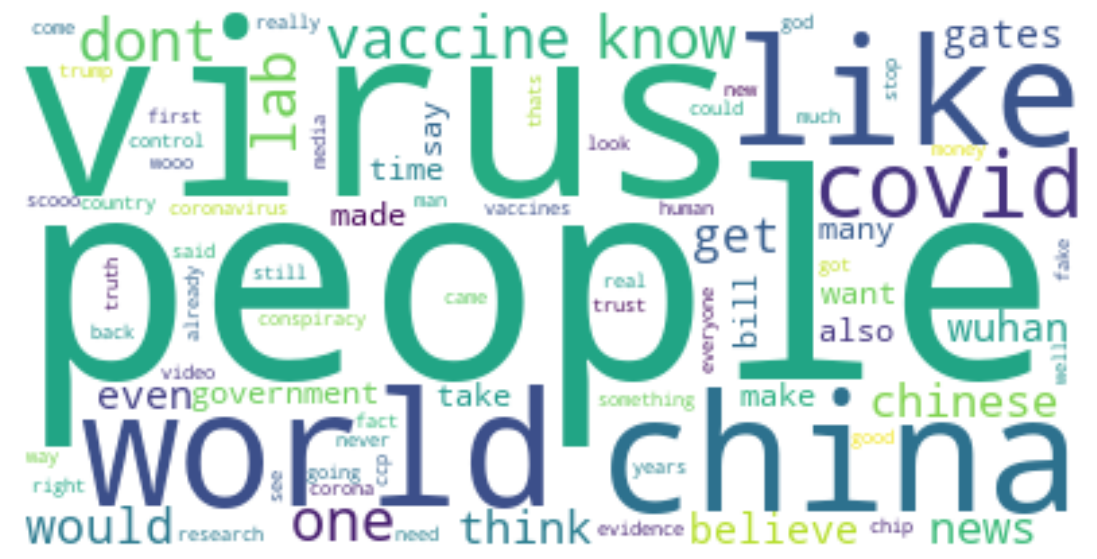

In [11]:
from wordcloud import WordCloud
text = ' '.join(df['text'])

# Calculate word frequency, count each word only once
word_freq = df['text'].str.split(expand=True).stack().value_counts().apply(lambda x: 1)

wordcloud = WordCloud(max_words=80, background_color="white", contour_width=3, contour_color='steelblue').generate_from_frequencies(word_freq)


plt.figure(figsize = (20,7))
# Display the generated image:
plt.imshow(wordcloud, interpolation= "bilinear")
plt.axis("off")
plt.show()

In [12]:

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

# Convert to list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


[['gave', 'piglett', 'virus', 'gives', 'diarrhea', 'death', 'named', 'sads', 'blame', 'lab', 'covid', 'outbreak', 'clearly', 'like', 'joking', 'around', 'work', 'place', 'fauci', 'always', 'seems', 'smirking', 'like', 'know', 'something', 'gotta', 'bring', 'grave']]


## Create document-feature matrix (DFM)
#### Build the Bigram, Trigram Models and Lemmatize

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Assuming you have a list of lemmatized tokens
# tokens_lemmatized = [...]

# Join the lemmatized tokens into sentences
documents = [' '.join(tokens) for tokens in data_words]

# Create a DataFrame
df = pd.DataFrame({'text': documents})

# Create a CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the text data
X = vectorizer.fit_transform(df['text'])

# Create a DataFrame from the DTM (Document-Term Matrix)
dfm = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Most frequent terms
top_features = dfm.sum().sort_values(ascending=False)

print("\nData top 50 terms:")
print("==================================\n")
# Display the top 50 terms
print(top_features.head(50))



Data top 50 terms:

people         12311
virus          11498
china          10009
world           6649
like            5940
covid           5680
vaccine         5399
lab             4897
dont            4840
know            4628
one             4500
would           4315
get             4243
chinese         3608
think           3395
news            3374
believe         3301
gates           3287
wuhan           3138
even            3130
government      3092
made            3054
take            3012
many            2861
say             2730
make            2713
time            2678
also            2660
bill            2653
want            2647
conspiracy      2613
video           2548
media           2533
see             2479
coronavirus     2398
truth           2362
wooo            2354
scooo           2353
going           2345
right           2304
need            2282
said            2279
fake            2209
trump           2166
way             2165
man             2072
new          

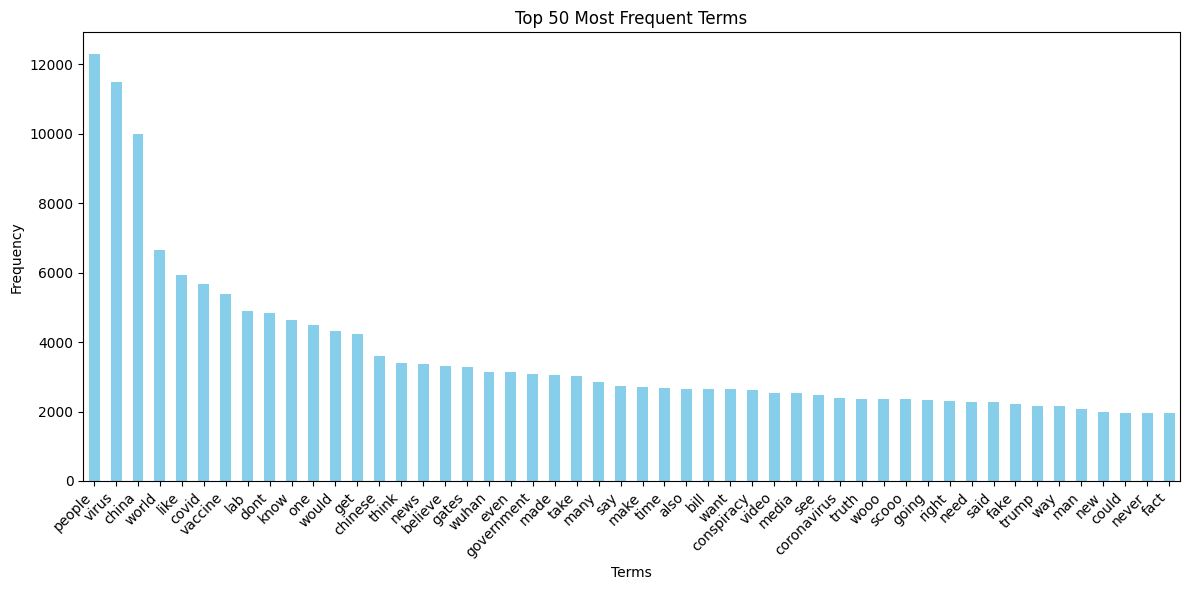

In [15]:
import matplotlib.pyplot as plt

# Plotting the top 50 terms
plt.figure(figsize=(12, 6))
top_features.head(50).plot(kind='bar', color='skyblue')
plt.title('Top 50 Most Frequent Terms')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Build the Bigram, Trigram Models and Lemmatize

Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# Model Selection

## Build the Topic Model
### To build the LDA topic model using LdaModel(), you need the corpus and the dictionary. Let’s create them first and then build the model. The trained topics (keywords and weights) are printed below as well.

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

To build the LDA topic model using LdaModel(), you need the corpus and the dictionary. Let’s create them first and then build the model. The trained topics (keywords and weights) are printed below as well.

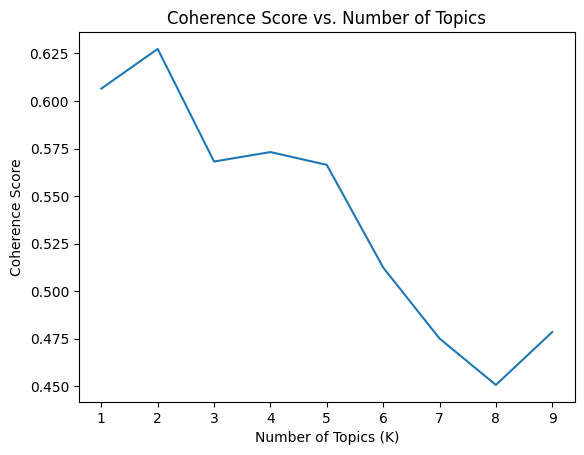

The best number of topics (K) is 2 with a coherence score of 0.6274039491970356


In [18]:
import gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Define a range of values for K (number of topics)
k_values = range(1, 10)  # Try values from 1 to 10

# Initialize a list to store coherence scores for each K
coherence_scores = []

# Iterate over different values of K
for k in k_values:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=k,  # Set the number of topics to k
                                                random_state=100,
                                                update_every=1,
                                                chunksize=10,
                                                passes=10,
                                                alpha='symmetric',
                                                iterations=100,
                                                per_word_topics=True)

    # Calculate coherence score for the LDA model
    coherence_model = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    # Append the coherence score to the list
    coherence_scores.append(coherence_score)

# Plot the coherence scores to find the best value of K
plt.plot(k_values, coherence_scores)
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(k_values)
plt.show()

# Find the best value of K with the highest coherence score
best_k = k_values[coherence_scores.index(max(coherence_scores))]
print(f"The best number of topics (K) is {best_k} with a coherence score of {max(coherence_scores)}")

In [19]:
# Build the final LDA model with the best K
final_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                   id2word=id2word,
                                                   num_topics=best_k,
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=10,
                                                   passes=10,
                                                   alpha='symmetric',
                                                   iterations=100,
                                                   per_word_topics=True)
pprint(final_lda_model.print_topics())

[(0,
  '0.051*"vaccine" + 0.029*"chip" + 0.020*"take" + 0.015*"get" + '
  '0.012*"mark_beast" + 0.011*"track" + 0.010*"use" + 0.010*"people" + '
  '0.010*"covid" + 0.009*"world"'),
 (1,
  '0.024*"people" + 0.021*"say" + 0.014*"lie" + 0.012*"believe" + 0.011*"get" '
  '+ 0.010*"think" + 0.010*"tell" + 0.010*"government" + 0.009*"see" + '
  '0.008*"video"')]


## Metrics

In [20]:

# Compute Perplexity
print('\nPerplexity: ', final_lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
coherence_model_lda = CoherenceModel(model=final_lda_model, texts=data_ready, dictionary=id2word, coherence='c_v') # CoherenceModel used for evaluation of topic models.
coherence_lda = coherence_model_lda.get_coherence() # Get coherence value based on pipeline parameters.
print('\nCoherence Score: ', coherence_lda) # Print the Coherence Score


Perplexity:  -8.395242954121116

Coherence Score:  0.6274039491970356


# What is the Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.



In [21]:
import pandas as pd

def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics = []

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Initialize variables to store dominant topic info
        dominant_topic = None
        topic_contribution = None
        topic_keywords = None

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                dominant_topic = int(topic_num)
                topic_contribution = round(prop_topic, 4)
            else:
                break

        # Remove square brackets and comma-separated values from text
        cleaned_text = ' '.join(texts[i]).replace('[', '').replace(']', '').replace(',', '')

        # Add dominant topic info and cleaned text to the output
        sent_topics.append({
            'Dominant_Topic': dominant_topic,
            'Perc_Contribution': topic_contribution,
            'Topic_Keywords': topic_keywords,
            'Text': cleaned_text
        })

    # Convert list of dictionaries into DataFrame
    sent_topics_df = pd.DataFrame(sent_topics)
    return sent_topics_df

# Call the function with appropriate arguments
df_topic_sents_keywords = format_topics_sentences(ldamodel=final_lda_model, corpus=corpus, texts=data_ready)

# Print or return the resulting DataFrame
df_topic_sents_keywords


,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,0,0.5318,"vaccine, chip, take, get, mark_beast, track, u...",give virus give diarrhea death name sad blame ...
1,1,0.8243,"people, say, lie, believe, get, think, tell, g...",america speak
2,0,0.5895,"vaccine, chip, take, get, mark_beast, track, u...",carry covid earth theory match evidence make d...
3,0,0.8246,"vaccine, chip, take, get, mark_beast, track, u...",tragedy cause whole world
4,1,0.7937,"people, say, lie, believe, get, think, tell, g...",liar_liar complete incompetence
...,...,...,...,...
54771,0,0.6508,"vaccine, chip, take, get, mark_beast, track, u...",black guy business school medical freak expert
54772,0,0.6131,"vaccine, chip, take, get, mark_beast, track, u...",big_pharma suppose drug competitor bias
54773,0,0.7017,"vaccine, chip, take, get, mark_beast, track, u...",wrong force vaccine population
54774,0,0.8995,"vaccine, chip, take, get, mark_beast, track, u...",current politicize pandemic cost


In [22]:
# Save the DataFrame to a CSV file
df_topic_sents_keywords.to_csv('YTdominant_topic_sents_keywords.csv', index=False)

# The most representative sentence for each topic

Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [24]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(1)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9945,"vaccine, chip, take, get, mark_beast, track, use, people, covid, world",able confirm pathogen filterpasse virus susceptible ether treatment indicate lipid envelope able...


# Frequency Distribution of Word Counts in Documents

When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

# Word Clouds of Top N Keywords in Each Topic

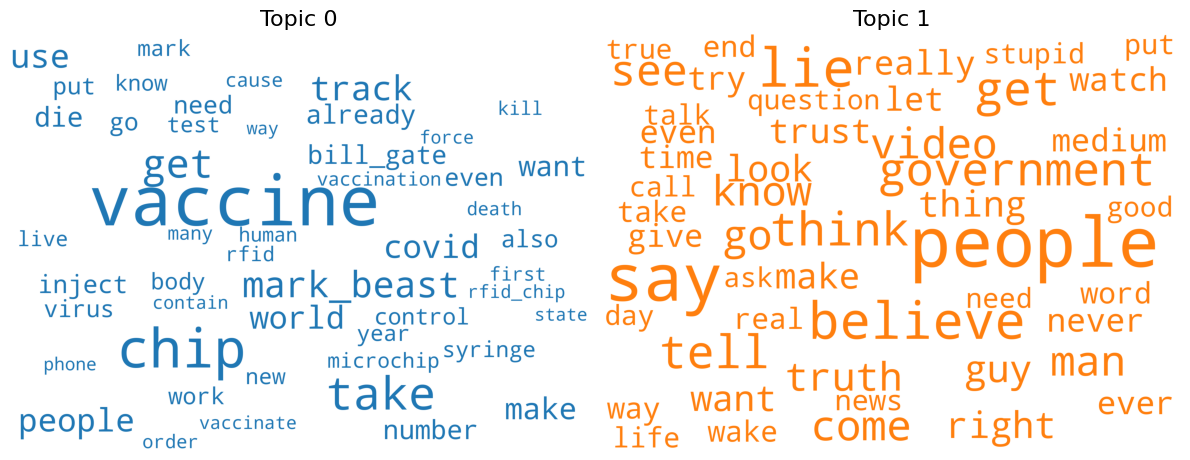

In [25]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = final_lda_model.show_topics(num_words=50,formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(12,11), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

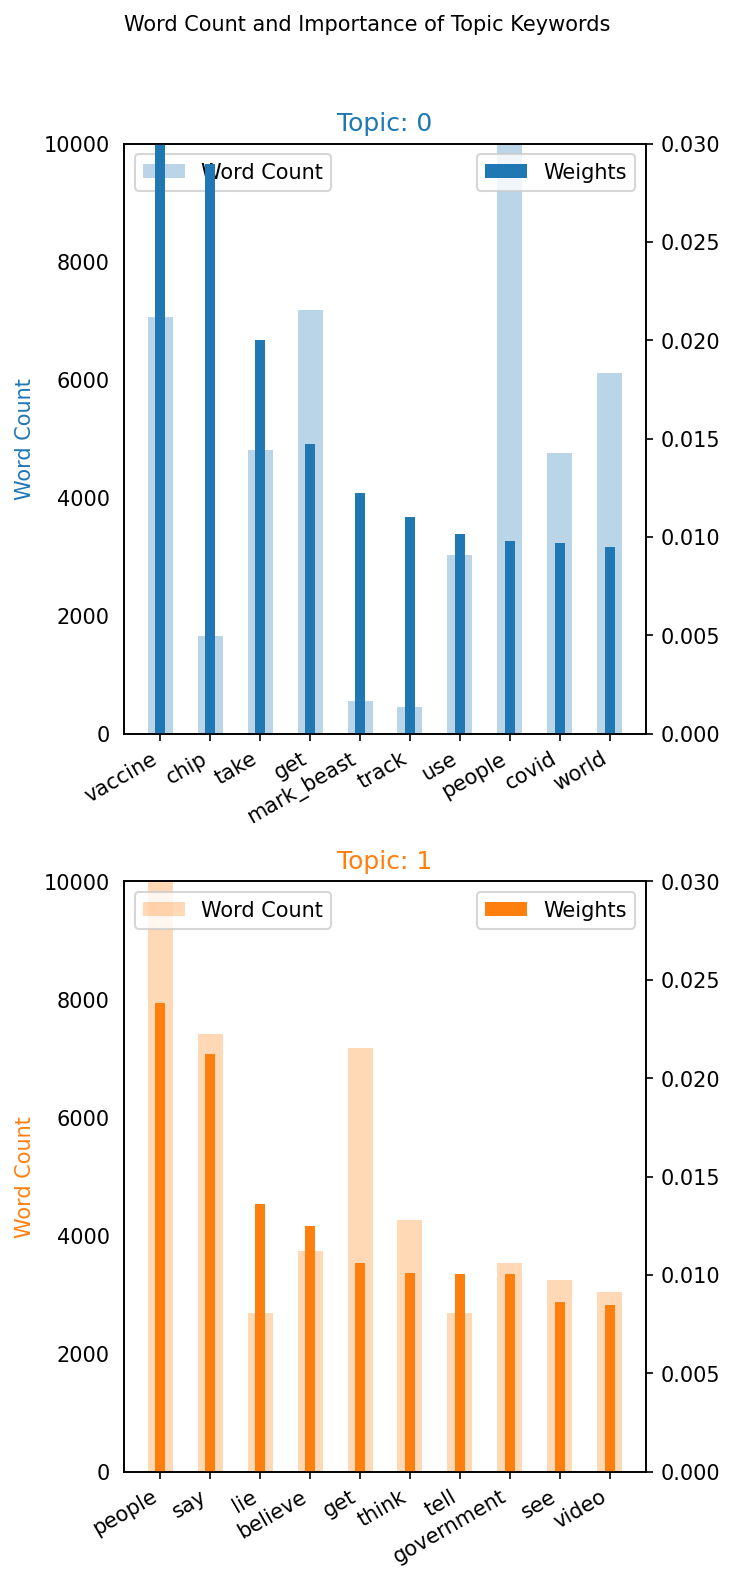

In [27]:
from collections import Counter
topics = final_lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 1, figsize=(5,10), sharey=True, dpi=150)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=10, y=1.05)
plt.show()

# Topic Analyses

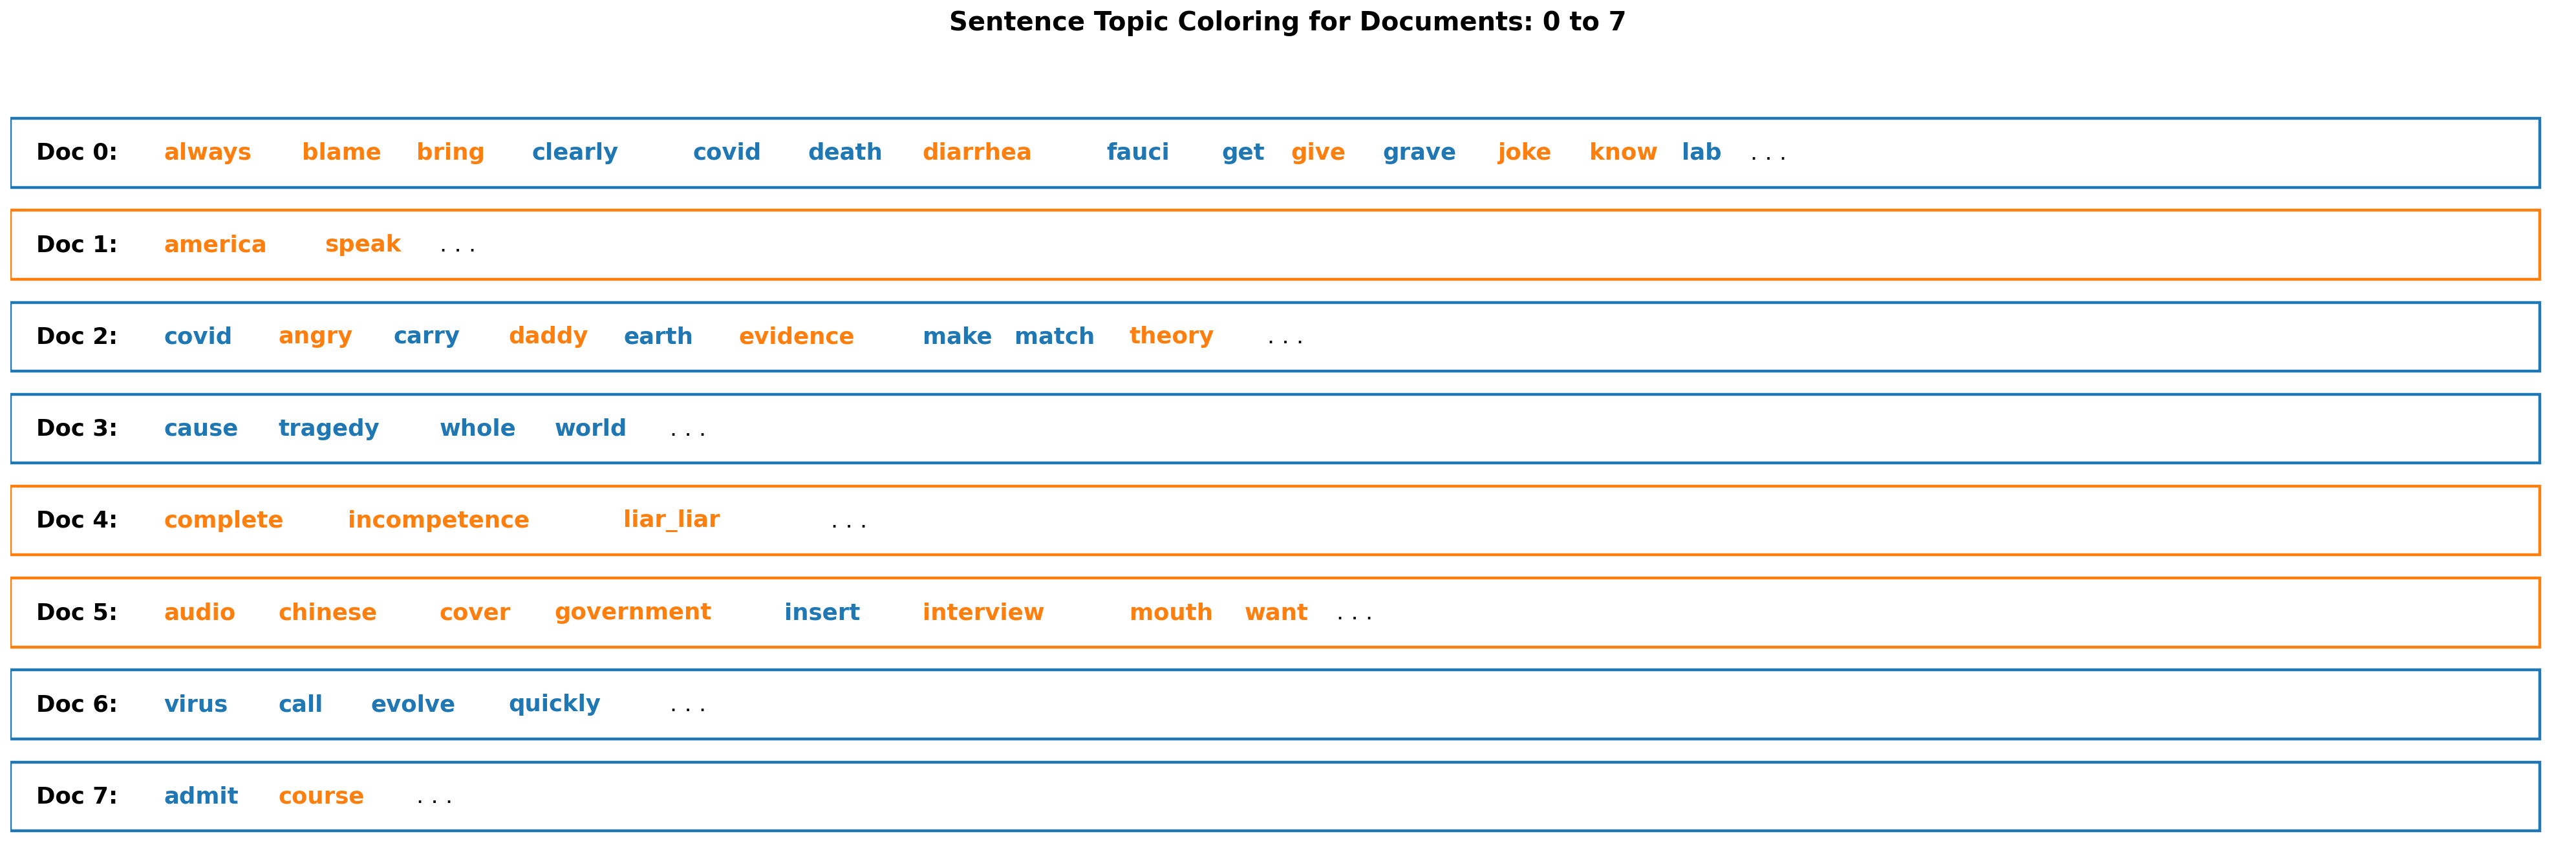

In [28]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=final_lda_model, corpus=corpus, start = 0, end = 9):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(25, (end-start)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(final_lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=18, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

# What are the most discussed topics in the documents?

In [29]:
def topics_per_document(model, corpus, start=0, end=None):
    corpus_sel = corpus[start:end] if end is not None else corpus[start:]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=final_lda_model, corpus=corpus, end=None)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in final_lda_model.show_topics(formatted=False)
                                 for j, (topic, wt) in enumerate(topics) if j < 5]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [30]:
df_top3words

,topic_id,words
0,0,"vaccine, \nchip, \ntake, \nget, \nmark_beast"
1,1,"people, \nsay, \nlie, \nbelieve, \nget"


In [31]:
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
dominant_topic_in_each_doc

Dominant_Topic
0    25232
1    29544
dtype: int64

### The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
### The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

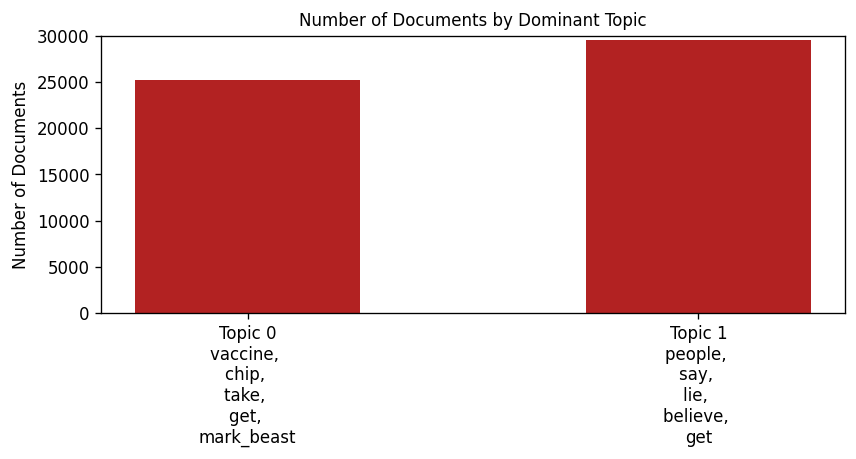

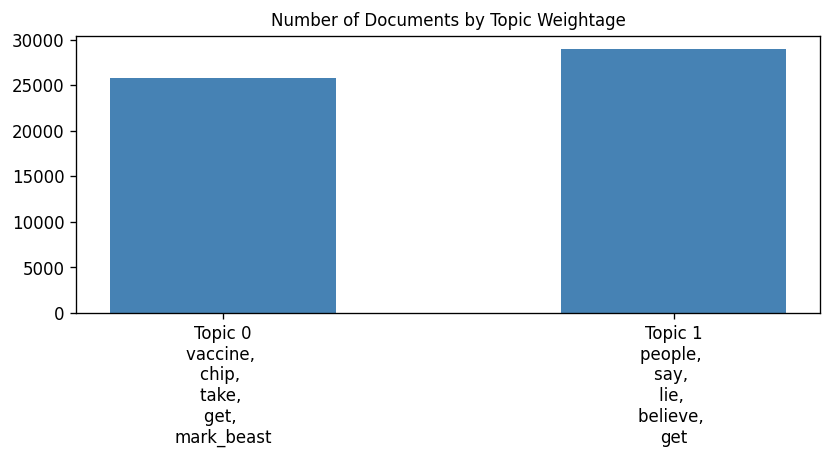

In [33]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# Plot
fig, ax1 = plt.subplots(figsize=(8, 3), dpi=120)
fig, ax2 = plt.subplots(figsize=(8, 3), dpi=120)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 30000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


In [ ]:
# pyLDAvis is insatlled to display the models
!pip install pyLDAvis

**Intertopic Distance Map (via multidimensional scaling)**
Visualize the topics-keywords

In [34]:
# Visualize the topicss
# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(final_lda_model, corpus, id2word) # General Use. prepare(): transform and prepare a LDA model's data for visualization
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.203243  0.0       1        1  53.257532
1     -0.203243  0.0       2        1  46.742468, topic_info=         Term          Freq         Total Category  logprob  loglift
245   vaccine  20293.000000  20293.000000  Default  30.0000  30.0000
4351     chip  11434.000000  11434.000000  Default  29.0000  29.0000
113       say   7351.000000   7351.000000  Default  28.0000  28.0000
123       lie   4707.000000   4707.000000  Default  27.0000  27.0000
151   believe   4317.000000   4317.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
8         get   3663.045774   9475.249612   Topic2  -4.5483  -0.1899
46       want   2046.210082   5038.385874   Topic2  -5.1306  -0.1406
29       make   1983.411033   5319.477458   Topic2  -5.1618  -0.2260
9        give   1570.181378   2416.838103   Topic2  -5.3954   0.3292
212      even   1609.479874   3883.760434   Topic2  -5.3707  -0.1204

[136 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
150       1  0.997279  already
150       2  0.002700  already
201       1  0.999595     also
201       2  0.000473     also
1017      1  0.007409      arm
...     ...       ...      ...
35        2  0.001070    world
980       1  0.004189    wrong
980       2  0.995938    wrong
262       1  0.999551     year
262       2  0.000569     year

[200 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])